In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import norm
from scipy.interpolate import interp1d

def stochasticity(timeseries, h=0.1, n=51, dt=0.01, PLOT=True, ERR=False, alpha=0.05):
    if timeseries is None:
        timeseries = np.random.normal(0, 1, int(1e4))

    timeseries[np.isnan(timeseries)] = 0
    bw = h * np.std(timeseries)
    N = len(timeseries)

    dx = np.diff(timeseries)
    binned_ts = np.linspace(min(timeseries), max(timeseries), n)
    Kmat = np.zeros((n, N-1))

    for i in range(N-1):
        Kmat[:, i] = (1 / np.sqrt(2 * np.pi * bw**2)) * np.exp(-0.5 * (timeseries[i] - binned_ts)**2 / bw**2)

    F_x = np.zeros(n)
    M_x = np.zeros(n)

    for i in range(n):
        Ksum = np.sum(Kmat[i, :])
        F_x[i] = (1 / dt) * np.sum(Kmat[i, :] * dx) / Ksum
        M_x[i] = (1 / dt) * np.sum(Kmat[i, :] * dx**2) / Ksum

    interp_F = interp1d(binned_ts, F_x, kind='linear', fill_value="extrapolate")
    interp_M = interp1d(binned_ts, M_x, kind='linear', fill_value="extrapolate")

    F_t = interp_F(timeseries)
    M_t = interp_M(timeseries)

    t = np.arange(1, N + 1) * dt

    if ERR:
        norm_K = (2 * np.sqrt(np.pi))**-1
        f_x = M_x.copy()
        M2_x = M_x.copy()
        M_x_up = M_x.copy()
        M_x_low = M_x.copy()
        F2_x = M2_x.copy()
        F_x_up = M2_x.copy()
        F_x_low = M2_x.copy()

        for i in range(n):
            Ksum = np.sum(Kmat[i, :])
            f_x[i] = np.sum(Kmat[i, :]) / N
            F2_x[i] = np.sum(Kmat[i, :] * ((dx/dt) - F_x[i])**2) / Ksum
            M2_x[i] = np.sum(Kmat[i, :] * ((dx**2/dt) - M_x[i])**2) / Ksum
            D_M = (1-alpha/2) * np.sqrt(norm_K * M2_x[i] / (N * bw * f_x[i]))
            D_F = (1-alpha/2) * np.sqrt(norm_K * F2_x[i] / (N * bw * f_x[i]))
            M_x_up[i] = M_x[i] + D_M
            M_x_low[i] = M_x[i] - D_M
            F_x_up[i] = F_x[i] + D_F
            F_x_low[i] = F_x[i] - D_F

        interp_M_low = interp1d(binned_ts, M_x_low, kind='linear', fill_value="extrapolate")
        interp_M_up = interp1d(binned_ts, M_x_up, kind='linear', fill_value="extrapolate")
        interp_F_low = interp1d(binned_ts, F_x_low, kind='linear', fill_value="extrapolate")
        interp_F_up = interp1d(binned_ts, F_x_up, kind='linear', fill_value="extrapolate")

        M_t_low = interp_M_low(timeseries)
        M_t_up = interp_M_up(timeseries)
        F_t_low = interp_F_low(timeseries)
        F_t_up = interp_F_up(timeseries)

        if PLOT:
            plt.plot(t, F_t,'ko')
            plt.plot(t, F_t_up, 'r-', linewidth=1)
            plt.plot(t, F_t_low, 'r-', linewidth=1)
            plt.xlabel('Time (s)')
            plt.ylabel('F(x,t)')
            plt.show()
            plt.plot(t, M_t,'ko')
            plt.plot(t, M_t_up, 'r-', linewidth=1)
            plt.plot(t, M_t_low, 'r-', linewidth=1)
            plt.xlabel('Time (s)')
            plt.ylabel('M(x,t)')
            plt.show()
            plt.plot(binned_ts, F_x, 'ko')
            plt.plot(binned_ts, F_x_up, 'r-', linewidth=1)
            plt.plot(binned_ts, F_x_low, 'r-', linewidth=1)
            plt.xlabel('x')
            plt.ylabel('F(x,t)')
            plt.show()
            plt.plot(binned_ts, M_x,'ko')
            plt.plot(binned_ts, M_x_up, 'r-', linewidth=1)
            plt.plot(binned_ts, M_x_low, 'r-', linewidth=1)
            plt.xlabel('x')
            plt.ylabel('M(x,t)')
            plt.show()

        return {
            "t": t, "F_t": F_t, "M_t": M_t, "F_t_low": F_t_low, "F_t_up": F_t_up,
            "F_x_low": F_x_low, "F_x_up": F_x_up, "M_t_low": M_t_low, "M_t_up": M_t_up,
            "x": binned_ts, "F_x": F_x, "M_x": M_x, "M_x_low": M_x_low, "M_x_up": M_x_up
        }
    else:
        if PLOT:
            plt.plot(t, F_t,'ko')
            plt.xlabel('Time (s)')
            plt.ylabel('F(x,t)')
            plt.show()
            plt.plot(t, M_t,'ko')
            plt.xlabel('Time (s)')
            plt.ylabel('M(x,t)')
            plt.show()
            plt.plot(binned_ts, F_x,'ko')
            plt.xlabel('x')
            plt.ylabel('F(x,t)')
            plt.show()
            plt.plot(binned_ts, M_x,'ko')
            plt.xlabel('x')
            plt.ylabel('M(x,t)')
            plt.show()

        return {"t": t, "F_t": F_t, "M_t": M_t, "x": binned_ts, "F_x": F_x, "M_x": M_x}

## **Example:**

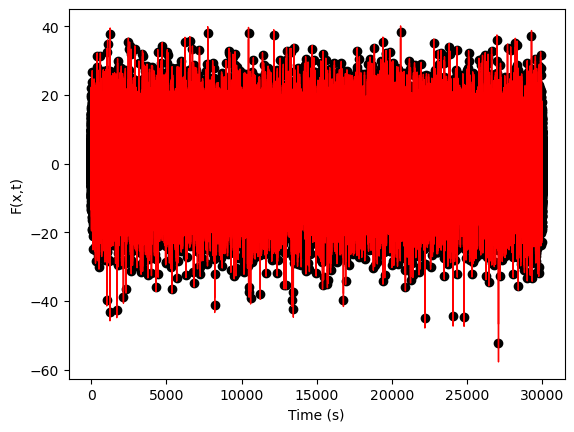

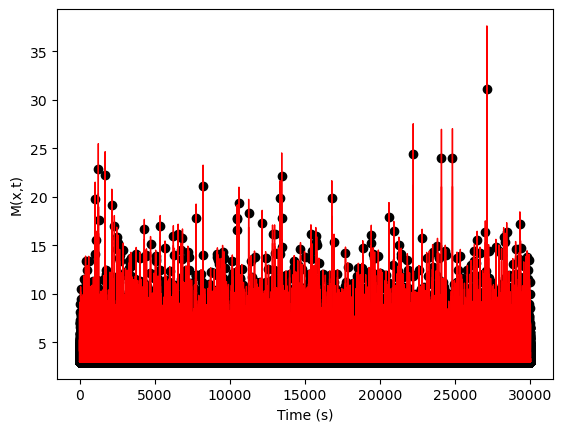

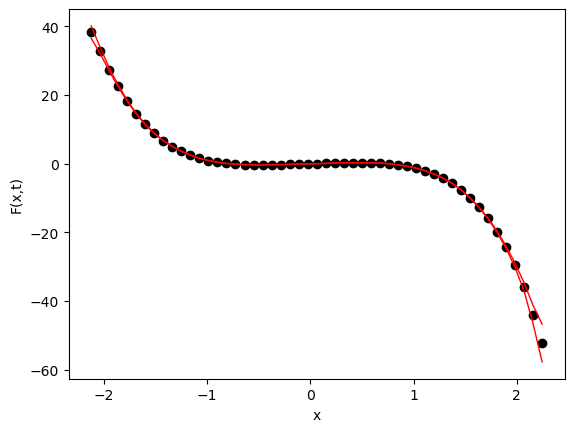

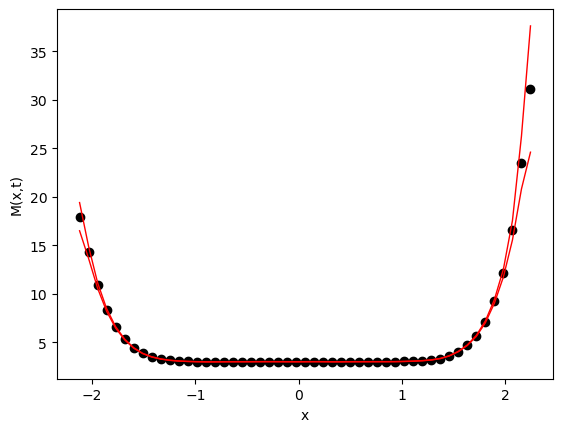

In [2]:
n = 3000000
etha = np.random.normal(0,1,n)
x=0.1
dt= 0.01
data = []
for i in range(n):
  dx = (x-x**3-x**5)*dt + ((3*dt)**(1/2))*etha[i]
  x= x+dx
  data.append(x)

df = np.array(data)

output = stochasticity(df, PLOT=True, ERR=True)